# Notebook 1: Agent based simulations of particles in a potential

In this notebook we explore using the JAX ecosystem to simulate the stochastic evolution of particles in a potential.
In particular, we'll use [`diffrax`](https://docs.kidger.site/diffrax/) to sample particle trajectories.


In [1]:
import os
import warnings
import time
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import jax
jax.config.update("jax_enable_x64", True)  # use 64-bit precision
import jax.numpy as jnp
import jax.random as jrandom

import diffrax as dfrx
from diffrax import diffeqsolve, MultiTerm, ODETerm, WeaklyDiagonalControlTerm
from diffrax import VirtualBrownianTree, SaveAt, DiscreteTerminatingEvent
from diffrax import SpaceTimeLevyArea

In [2]:
# Random number generator seeds

seed = 12345

rng = np.random.default_rng(seed=seed)  # Numpy PRNG
key = jrandom.PRNGKey(seed=rng.integers(2**32))  # JAX key

outdir = "out/"
os.makedirs(outdir, exist_ok=True)

## Generating trajectories of particles in a potential

Let's start by defining the potential:
$$
\begin{align*}
    \phi(x,y) &= -\gamma x - \alpha(x - x_c)y^2 + \beta y^4 \\
        \alpha &= 3.0 \\
        \beta &= 0.5 \\
        \gamma &= 2.0 \\
        x_c &= 0.5
\end{align*}
$$
This potential has a single minimum when $x < x_c$ and undergoes a bifurcation at $x=x_c$.
When $x>x_c$, there are two minima. 
We will assume that there is a source defined by 
$$
s_0(x,y) = r \rho_0(x,y)
$$
where $\rho_0$ is a probability distribution defining the support of the source distribution, and $r$ is the injection rate, the rate at which new particles enter into the system.
We will use a multivariate gaussian for $\rho_0$, centered at $\boldsymbol{\mu}_0$ with covariance $\boldsymbol{\Sigma}_0$.
$$
\begin{align*}
    \rho_0 &= \frac{1}{2\pi} |\boldsymbol{\Sigma}_0|^{-1/2} \exp\left( -\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu}_0)^T \boldsymbol{\Sigma}_0^{-1} (\boldsymbol{x} - \boldsymbol{\mu}_0) \right) \\
    \boldsymbol{\mu}_0 &= \begin{bmatrix} 0 & 0 \end{bmatrix}^T \\
    \boldsymbol{\Sigma}_0 &= \begin{bmatrix} 0.01 & 0 \\ 0 & 0.2 \end{bmatrix}
\end{align*}
$$

Particles will immediately exit the system upon crossing a boundary $x=x_f$.
We will take
$$
x_f = 2.
$$

Incorporating noise, we'll use for the diffusion tensor
$$
\begin{align*}
    \mathbf{D} &= \begin{bmatrix} D_x & 0 \\ 0 & D_y \end{bmatrix} = \frac{1}{2}\begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 \end{bmatrix} \\
    D_x &= 0.01\\
    D_y &= 0.5
\end{align*}
$$

The time evolution of the probability distribution $\rho(x,y,t)$ is then governed by the Fokker-Planck equation
$$
\begin{align*}
    \frac{\partial\rho}{\partial t} &= \nabla\cdot(\rho\nabla\phi) 
        + D_x \frac{\partial^2\rho}{\partial x^2} 
        + D_y \frac{\partial^2\rho}{\partial y^2} 
        + r\rho_0 \\
    &= \rho\nabla^2\phi + \nabla\phi\cdot\nabla\rho
        + D_x \frac{\partial^2\rho}{\partial x^2} 
        + D_y \frac{\partial^2\rho}{\partial y^2} 
        + r\rho_0
\end{align*}
$$
with a condition on the sink boundary
$$
\rho(x,y,t) = 0, \text{ for } x>x_f
$$

In [3]:
#~~~  Define the potential function  ~~~#

alpha = 3.0   # potential parameter alpha (coefficient of y^2)
beta = 0.5    # potential parameter beta (coefficient of y^4)
gamma = 2     # potential parameter gamma (coefficient of x)
x_crit = 0.5  # potential parameter (bifurcation point x=x_c)

def phi(x):
    """Potential function. Input is an array of length 2."""
    x1 = x[0]  # x coord
    x2 = x[1]  # y coord
    x2sq = x2 * x2
    return -gamma*x1 - alpha*(x1 - x_crit)*x2sq + beta*x2sq*x2sq


print("phi([0, 0]) =", phi([0, 0]))
print("phi([0, 1]) =", phi([0, 1]))
print("phi([1, 0]) =", phi([1, 0]))

phi([0, 0]) = 0.0
phi([0, 1]) = 2.0
phi([1, 0]) = -2.0


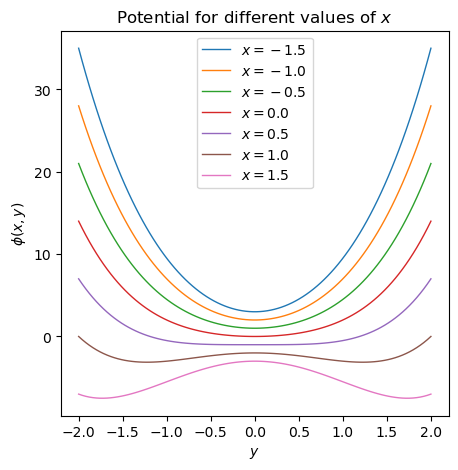

In [4]:
#~~~  Plot the potential for different values of x  ~~~#

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

xvals = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

ys = np.linspace(-2, 2, 100)
for x in xvals:
    xs = np.array([x * np.ones(ys.shape), ys]).T
    fs = jax.vmap(phi)(xs)
    ax.plot(ys, fs, linewidth=1, label=f"$x={x}$")

ax.legend()
ax.set_title("Potential for different values of $x$")
ax.set_xlabel("$y$")
ax.set_ylabel("$\phi(x, y)$");

In [5]:
#~~~  Define the system noise  ~~~#

diffusivity_x = 0.01    # diffusion constant in x
diffusivity_y = 0.5     # diffusion constant in y

In [6]:
#~~~  Classes for sources  ~~~#

class GaussianSource:

    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def center(self):
        return self.mean

    def sample(self, key, n):
        return jrandom.multivariate_normal(
            key, mean=self.mean, cov=self.cov, shape=[n]
        )
    

class PointSource:

    def __init__(self, point):
        self.point = point

    def center(self):
        return self.point

    def sample(self, key, n):
        return jnp.tile(self.point, [n, 1])
    

In [7]:
#~~~  Define the sources and sinks  ~~~#

x_sink = 4  # particles escape when x >= x_sink

# Define a gaussian source
source_mean = jnp.array([0, 0], dtype=jnp.float64)
source_sigma_x = 0.05
source_sigma_y = 0.5

source_cov = jnp.array([
    [source_sigma_x, 0], 
    [0, source_sigma_y]
], dtype=jnp.float64)


source = GaussianSource(source_mean, source_cov)

source_point = source.center()  # save the center of the source for plotting

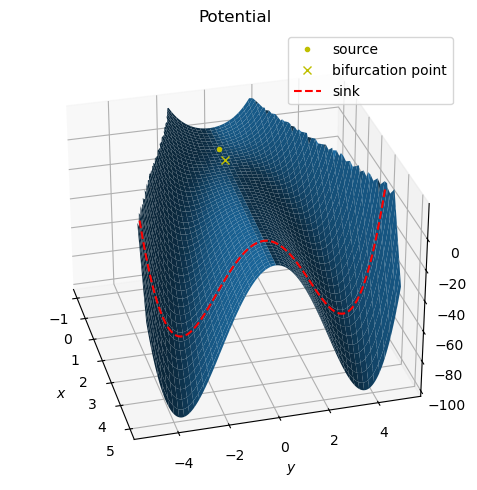

In [8]:
#~~~  Plot the potential function, source, and sink  ~~~#

xlims = [-1, x_sink + 1]
ylims = [-5, 5]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.plot_surface(
    xs, ys, z_plot.reshape(xs.shape),
)

# Plot the source point
ax.plot(*source_point, phi(source_point), 'y.', label='source')

# Plot the bifurcation point
ax.plot(x_crit, 0., phi([x_crit, 0]), 'yx', label='bifurcation point')

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
phi_sink = jax.vmap(phi)(np.array([xs_sink, ys_sink]).T).reshape(xs_sink.shape)
phi_sink = np.where(phi_sink > clip, np.nan, phi_sink)
ax.plot(xs_sink, ys_sink, phi_sink, 'r--', label='sink')

ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Potential")

ax.view_init(30, -15)

plt.tight_layout()

## Defining the SDE terms

We can now define the dynamical system governing the stochastic evolution of particles in the potential.
We'll define the drift and diffusion functions below, which should have arguments `t` (time), `y` (state), and `args` (any additional arguments).
These define the SDE governing the system.

$$
d\boldsymbol{x}(t) = f(t,\boldsymbol{x}(t))dt + g(t, \boldsymbol{x}(t)) dW(t)
$$

Defining both functions `f` and `drift` (as well as both `g` and `diffusion`), below, is primarily for ease of use.
Functions `f` and `g` have simple signatures, while `drift` and `diffusion` have the signatures appropriate for use with the Diffrax function `diffeqsolve`, which we will make use of soon.

In [9]:
#~~~  Define the drift and diffusion functions  ~~~#

# Define drift and diffusion functions
def f(x):
    """Defines the drift, given by the negative gradient of the potential."""
    return -jax.grad(phi)(x)

def g():
    """Defines the diagonal diffusion tensor."""
    return jnp.sqrt(2. * jnp.array([diffusivity_x, diffusivity_y]))


# Wrap the functions above with the required argument signature: (t, y, args).
# This is required by diffrax.
@jax.jit
def drift(t, y, args):
    """Drift term f of the SDE."""
    return f(y)

@jax.jit
def diffusion(t, y, args):
    """Diffusion term g of the SDE. 
    
    Returns an array of length 2 containing sigma_x and sigma_y, defining the 
    diagonal elements of the diffusion tensor according to D_x=sqrt(2 sigma_x).
    """
    return g()


print("f(1, 1) =", f(jnp.array([1., 1.])))
print("    g() =", g())

f(1, 1) = [5. 1.]
    g() = [0.14142136 1.        ]


## Sampling the SDE with diffrax

Now that we have the drift and diffusion functions defined, we can use diffrax to sample trajectories.
We'll first define a function `simulate_path` that samples a trajectory of an individual cell.
This function will use a prespecified solver supplied by diffrax, along with a stepsize controller. 
The full list of available solvers can be found in the [diffrax documentation](https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/).
Below we use the solver `ShARK`, which is recommended for additive noise in the [docs](https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/#additive-noise). 

We will also define a function that checks to see if the particle has reached the sink, at which point the solver will terminate early.

Note that in diffrax, the convention is to use `y` as the state variable for a system.
This is why in the `check_sink` function below, we use `state.y[0]` to access the $x$ coordinate of the evolving particle, and why `y0=...` appears in the call to `diffeqsolve`.

In [10]:
#~~~  Specify solver, stepsize controller, and early halting function.  ~~~#

# Specify a solver
solver = dfrx.ShARK()

# Specify a stepsize controller
stepsize_controller = dfrx.PIDController(
    pcoeff=0.1, icoeff=0.3, dcoeff=0, 
    rtol=1e-3, atol=1e-6, 
    dtmin=1e-5, dtmax=1e-1
)

# Early termination function
def check_sink(state, **kwargs):
    return state.y[0] > x_sink

discrete_terminating_event = DiscreteTerminatingEvent(cond_fn=check_sink)


#~~~  Define simulation functions  ~~~#

@jax.jit
def simulate_path(key, t0, y0, tfin, ts_save, dt):
    """Simulate the evolution of a single particle over an interval of time.

    Args:
        key (PRNGKey) : JAX RNG key.
        t0 (float) : start time.
        y0 (Float[Array]) : initial condition.
        tfin (float) : end time.
        ts_save (Float[Array]) : times at which to save the state.
        dt (float) : (initial) solver step size.

    Returns:
        (Float[Array]) : Times at which the state was saved. Shape (nsaves,).
        (Float[Array]) : Saved states. Shape (nsaves, 2). Note that if the cell 
            escapes, the saved state for any subsequent time will contain `inf`. 
    """
    
    # Sample a brownian path.
    key, subkey = jrandom.split(key, 2)
    brownian_motion = VirtualBrownianTree(
        t0, tfin, tol=1e-6, 
        shape=(2,), 
        levy_area=SpaceTimeLevyArea,
        key=subkey
    )

    # Wrap the drift and diffusion terms into a single MultiTerm object.
    terms = MultiTerm(
        ODETerm(drift), 
        WeaklyDiagonalControlTerm(diffusion, brownian_motion)
    )
    
    # We save at the times specified in `ts_save`
    saveat = SaveAt(ts=ts_save)
    sol = diffeqsolve(
        terms,
        solver,
        t0=t0, t1=tfin, dt0=dt,
        y0=y0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=discrete_terminating_event,
        max_steps=None,
    )
    
    # Return the times and states corresponding to `ts_save`
    return sol.ts, sol.ys


@jax.jit
def simulate_ensemble(key, t0s, y0s, tfin, ts_save, dt):
    """Simulate an ensemble of cells, all evolving to the same final time.
    
    Args:
        key (PRNGKey) : JAX RNG key.
        t0s (Float[Array]) : start times of each cell.
        y0s (Float[Array]) : initial state of each cell.
        tfin (float) : end time for all cells.
        ts_save (Float[Array]) : times at which to save the state. All values 
            must be between the maximum of t0s and the end time tfin.
        dt (float) : initial timestep.

    Returns:
        (Float[Array]) : Times at which the state was saved. Shape (ncells, nsaves,).
        (Float[Array]) : Saved states. Shape (ncells, nsaves, 2).
    """
    # Determine the number of cells based on the given initial conditions.
    ncells = y0s.shape[0]
    # Get an array of subkeys to seed each path.
    keys = jrandom.split(key, ncells)
    # Map `simulate_path` across the keys, start times, and initial conditions.
    ts, xs = jax.vmap(simulate_path, (0,0,0,None,None,None))(
        keys, t0s, y0s, tfin, ts_save, dt
    )
    return ts, xs

## Example simulation

Here is a demonstration of simulating an ensemble of cells, all evolving from time $t_0=0$ to a final time $t_1$.
We plot the trajectory of each cell.
Note that because the cells potentially exit the system at different times, the endpoints of each trajectory correspond to different times.
These exit times are plotted as well.

Finished in 4.064 sec


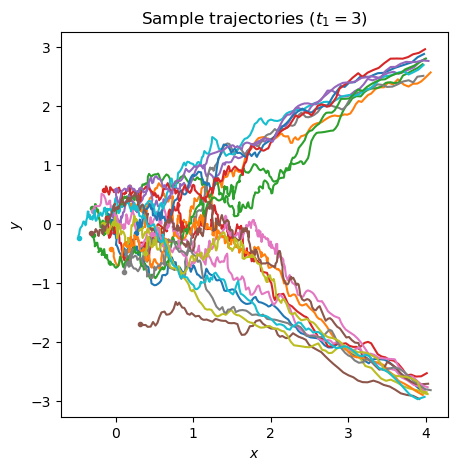

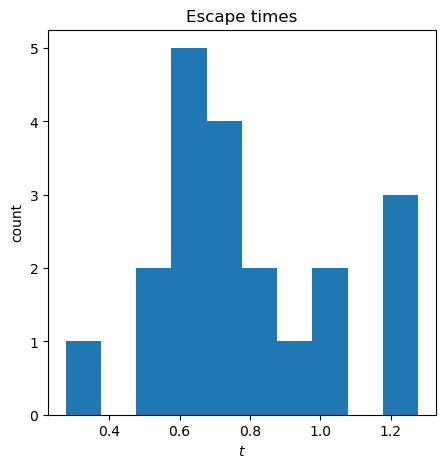

In [11]:
#~~~  Simulate an ensemble of cells and plot the trajectories  ~~~#

ntraj = 20      # Number of cells
tfin = 3        # Simulation end time for all trajectories
dt = 1e-2       # Timestep

# Start all cells at time t=0
t0s = jnp.zeros(ntraj, dtype=jnp.float64)

# Sample initial conditions from the source distributions
key, subkey = jrandom.split(key, 2)
y0s = source.sample(subkey, ntraj)

# Save at equally spaced timepoints between t=0 and t=tfin
ts_save = jnp.linspace(0, tfin, 1001)

# Run the simulation
time0 = time.time()
key, subkey = jrandom.split(key, 2)
all_ts, all_ys = simulate_ensemble(
    subkey, t0s, y0s, 
    tfin, ts_save, dt,
)
time1 = time.time()
print(f"Finished in {time1-time0:.4g} sec")

# Plot the resulting trajectories
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(len(all_ts)):
    ts = all_ts[i]
    ys = all_ys[i]
    p, = ax.plot(ys[0,0], ys[0,1], '.')
    ax.plot(ys[:,0], ys[:,1], color=p.get_color())

ax.set_title(f"Sample trajectories ($t_1={tfin}$)")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$");


# Distribution of the exit times
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

escape_times = []
for i in range(len(all_ts)):
    ts = all_ts[i]
    if not jnp.all(jnp.isfinite(ts)):
        t_escape = max(ts[jnp.isfinite(ts)])
        escape_times.append(t_escape)

ax.hist(escape_times)

ax.set_title("Escape times")
ax.set_xlabel("$t$")
ax.set_ylabel("count");

In [12]:
#~~~  Examine the trajectories returned by the simulation  ~~~#

print("shape of returned trajectory results:", all_ys.shape, '\n')

print("Trajectory 0:")
traj0 = all_ys[0]
print(traj0, '\n')

print("Last 10 finite states:")
finite_states = traj0[jnp.any(jnp.isfinite(traj0), axis=1),:]
print(finite_states[-10:])

shape of returned trajectory results: (20, 1001, 2) 

Trajectory 0:
[[-0.10401043  0.13320498]
 [-0.10808338  0.16244066]
 [-0.10999421  0.18661994]
 ...
 [        inf         inf]
 [        inf         inf]
 [        inf         inf]] 

Last 10 finite states:
[[ 3.4243839  -2.28791681]
 [ 3.47158264 -2.29621477]
 [ 3.53096394 -2.33865173]
 [ 3.59347178 -2.41125784]
 [ 3.65000598 -2.49982641]
 [ 3.7191103  -2.57043425]
 [ 3.78600029 -2.63919404]
 [ 3.85744143 -2.71886248]
 [ 3.92394455 -2.7937148 ]
 [ 3.97979521 -2.80259973]]


The takeaway is that early stopping is fine, but leaves us with `nan` or `inf` values in the returned arrays.
We can determine which particles escape based on the final finite value. 
When a cell escapes, it satisfies $x>x_f$ so that its last saved $x$ coordinate is greater than $x_f$.
There is an edge case where at the last timestep a cell crosses the border, so that the final saved $x$ value is larger than $x_f$, but no `nan` or `inf` value appears in the saved array. 
This edge case shouldn't cause us much concern for the moment.

## Simulating an ensemble and taking a snapshot

We now want to simulate an ensemble of cells, where each cell enters the trajectory at a particular time.
Thus, we need to simulate with distinct start, or *injection*, times, as opposed to starting all cells at time $t_0=0$.
This hinders our ability (if we restrict ourselves to using diffrax) to return the full trajectory of individual cells, as we can only save a cell's state at times between when it enters the system, and the terminal time $t_1$.
Let $\boldsymbol{x}^{(i)}(t)$ be the state of the $i$-th cell, and let $t_0^{(i)}$ be the time at which cell $i$ enters the system.
Note again that the terminal time $t_1$ is shared across all cells.
We can safely save the state of *all* cells at times $t^*\in\left[\max_{i}\left\{t_0^{(i)}\right\}, t_1\right]$.
We will refer to this as a *snapshot* of the system.

Below, we specify $t^*$ and sample a specified number of injection times over a uniform interval $[0, t^*]$.
We then run an ensemble simulation and take a snaphot at time $t^*$.
Over this duration, cells should be expected to escape. 
We can identify escaped cells based on the returned final state: cells that escape will have a non-finite state value, as demonstrated above.

In [13]:
def sample_injection_times(key, ntraj, t0, t1):
    """Sample `ntraj` injection times uniformly between `t0` and `t1`.
    """
    injection_times = jrandom.uniform(
        key, (ntraj,), 
        dtype=jnp.float64, 
        minval=t0, 
        maxval=t1,
    )
    return jnp.sort(injection_times)

def sample_injection_times_with_rate(key, rate, t0, t1):
    """Sample injection times occurring at a specified rate.
    """
    injection_times = jnp.array([], dtype=jnp.float64)
    current_time = t0
    batch_size = 1000
    while current_time < t1:
        key, subkey = jrandom.split(key, 2)
        increments = -jnp.log(1 - jrandom.uniform(subkey, (batch_size,))) / rate
        ts = current_time + jnp.cumsum(increments)
        injection_times = jnp.concatenate([injection_times, ts[ts < t1]], 0)
        current_time = ts[-1]
    return injection_times
    

In [14]:
#~~~  Some helper functions to identify escaped cells  ~~~#

def filter_nans(ts, xs):
    """Remove nans/infs from the returned trajectory times and states.
    
    Args:
        ts (Float[Array]) : Saved timepoints. Shape (nsaves,).
        xs (Float[Array]) : Saved states. Shape (nsaves, 2).

    Returns:
        (Float[Array]) : subset of `ts` that are finite.
        (Float[Array]) : corresponding states, a subset of `xs`.
    """
    screen = jnp.isfinite(ts)
    return ts[screen], xs[screen]


def count_nonescaped(snapshot_times):
    """Count cells remaining in the system based on the returned snapshot time.

    Assuming a snapshot is taken at time tstar, cells that have escaped will 
    contain nan or inf in the returned timepoint array. Cells that are remaining
    will have the value tstar instead.
    
    Args:
        snapshot_times (Float[Array]) : Shape (ncells, 1).

    Returns:
        (int) Number of cells that did NOT escape the system.
    """
    k = snapshot_times.shape[1]
    assert k == 1, f"Expected input to have shape (*,1). Got shape (*,{k})."
    return np.count_nonzero(jnp.isfinite(snapshot_times))


def count_escaped(snapshot_times):
    """Count cells that escaped the system based on the returned snapshot time.

    Assuming a snapshot is taken at time tstar, cells that have escaped will 
    contain nan or inf in the returned timepoint array. Cells that are remaining
    will have the value tstar instead.
    
    Args:
        snapshot_times (Float[Array]) : Shape (ncells, 1).

    Returns:
        (int) Number of cells that escaped the system.
    """
    k = snapshot_times.shape[1]
    assert k == 1, f"Expected input to have shape (*,1). Got shape (*,{k})."
    return len(snapshot_times) - count_nonescaped(snapshot_times)


def get_remaining_cells(snapshot_times, snapshot_states):
    """Get the cells remaining in the system, as well as the counts.
    
    Args:
        snapshot_times (Float[Array]) : Shape (ncells, 1).
        snapshot_states (Float[Array]) : Shape (ncells, 1, 2).

    Returns:
        (Float[Array]) : Cell states remaining in the system. Shape (?,2).
        (int) : Number of remaining cells.
        (int) : Number of escaped cells.
    """
    count_remaining = 0
    count_escaped = 0
    remaining_cells = np.empty([count_nonescaped(snapshot_times), 2])
    for t, x in zip(snapshot_times.squeeze(1), snapshot_states.squeeze(1)):
        if (not jnp.isfinite(t)) or (x[0] > x_sink):
            count_escaped += 1
            continue
        remaining_cells[count_remaining] = x
        count_remaining += 1
    return np.array(remaining_cells), count_remaining, count_escaped


In [15]:
#~~~  Simulate an ensemble of cells and take a snapshot at the end  ~~~#

ntraj = 200
tfin = 4  # Simulation end time for all trajectories
tstar = tfin  # Time at which snapshot is taken. Should be no greater than `tfin`.
dt = 1e-2  # Timestep

# Get uniformly distributed injection times over the interval [0, tstar)
key, subkey = jrandom.split(key, 2)
t0s = sample_injection_times(subkey, ntraj, 0, tstar) 

# Sample initial conditions from the source distributions
key, subkey = jrandom.split(key, 2)
y0s = source.sample(subkey, ntraj)  # jnp.tile(source, [ntraj, 1])

# Wrap the snapshot time in an array, as ts_save should be list-like
t_snapshot = jnp.array([tstar], dtype=jnp.float64)

# Run the simulation
time0 = time.time()
key, subkey = jrandom.split(key, 2)
all_ts, all_xs = simulate_ensemble(
    subkey, t0s, y0s, 
    tfin, t_snapshot, dt
)
time1 = time.time()
print(f"Finished in {time1-time0:.4g} sec")

print(f"{count_escaped(all_ts)}/{ntraj} cells escaped boundary.")

Finished in 8.419 sec
164/200 cells escaped boundary.


In [16]:
sampled_cells, n_remaining, n_escaped = get_remaining_cells(all_ts, all_xs)

print(f"{n_escaped}/{ntraj} cells escaped boundary.")

min_xy = sampled_cells.min(axis=0)
max_xy = sampled_cells.max(axis=0)
print(f"sampled x range: [{min_xy[0]:.4f}, {max_xy[0]:.4f}]")
print(f"sampled y range: [{min_xy[1]:.4f}, {max_xy[1]:.4f}]")

164/200 cells escaped boundary.
sampled x range: [-0.0045, 3.8897]
sampled y range: [-2.2469, 2.8268]


## Sampling a desired number of *remaining* cells

Here we demonstrate that we can repeatedly perform simulations until a desired number of cells have been captured in the system. 
We fix a batch size, the number of cells to simulate in each iteration, and uniformly sample injection times between $t_0=0$ and $t_1=t^*$.
At the end of the simulation, we will have captured some number of cells, the rest of which escape. 
We then resample injection times and repeat the simulation, adding the non-escaped cells to our set of captured cells. 
We do this until we have captured the desired number of trajectories.

Once we have captured the desired number of cells, we will have generated some number of total trajectories in the process. 
From this total, we can determine an empirical injection rate.

In [17]:
ntraj = 500  # Total number of cells we would like to have
batch_size = 1000  # Batch size for each iteration

total_cells = 0

sampled_cells = np.zeros([ntraj, 2], dtype=np.float64)
n_remaining = 0
n_escaped = 0

pbar = tqdm.tqdm(total=ntraj)
while n_remaining < ntraj:

    key, subkey = jrandom.split(key, 2)
    y0s = source.sample(subkey, batch_size)

    # Get uniformly distributed injection times over the interval [0, tstar)
    key, subkey1, subkey2 = jrandom.split(key, 3)
    t0s = sample_injection_times(subkey1, batch_size, 0, tstar)

    all_ts, all_xs = simulate_ensemble(
        subkey2, t0s, y0s, 
        tfin, t_snapshot, dt
    )

    for ts, xs in zip(all_ts, all_xs):
        ts, xs = filter_nans(ts, xs)
        # Stop if we've reached the total number of desired trajectories.
        if n_remaining >= ntraj:
            break
        # Check if the cell has "escaped" the potential.
        total_cells += 1
        if len(ts) == 0 or xs[0,0] > x_sink:
            n_escaped += 1
            continue
        else:
            sampled_cells[n_remaining] = xs
            pbar.update(1)
            n_remaining += 1
    pbar.refresh()

  0%|          | 0/500 [00:00<?, ?it/s]

Based on the number of cells we required to sample the desired number of remaining cells, we can determine an emprical injection rate.

In [18]:
empirical_source_rate = total_cells / tstar
print("Injection Rate r:", empirical_source_rate)

Injection Rate r: 745.25


### Generate plots

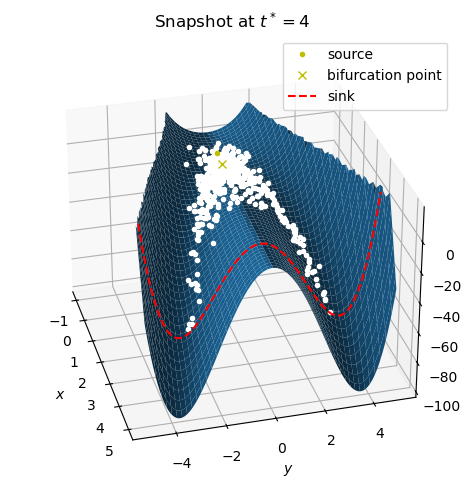

In [19]:
#~~~  Plot the 3d potential and the points sampled  ~~~#

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)  # Shape (nx*ny, 2)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.plot_surface(
    xs, ys, z_plot.reshape(xs.shape),
)


# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    jax.vmap(phi)(sampled_cells),
    'w.'
)

# Plot the source point
ax.plot(*source_point, phi(source_point), 'y.', label='source')

# Plot the bifurcation point
ax.plot(x_crit, 0., phi([x_crit, 0]), 'yx', label='bifurcation point')

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
phi_sink = jax.vmap(phi)(np.array([xs_sink, ys_sink]).T).reshape(xs_sink.shape)
phi_sink = np.where(phi_sink > clip, np.nan, phi_sink)
ax.plot(xs_sink, ys_sink, phi_sink, 'r--', label='sink')

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(f"Snapshot at $t^*={tstar}$")
ax.legend()

ax.view_init(30, -15)

plt.tight_layout()

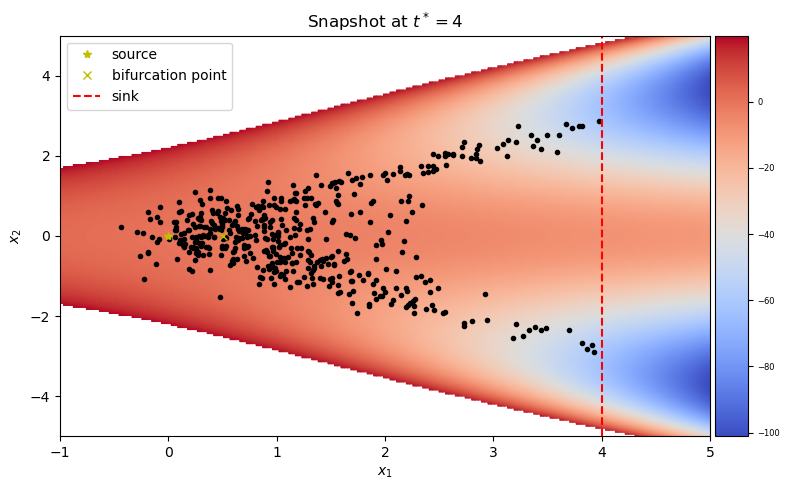

In [20]:
#~~~  Plot a 2d heatmap  ~~~#

fig, ax = plt.subplots(1, 1, figsize=(8,5))

xlims = [
    min(xlims[0], np.min(sampled_cells[:,0].min()) - 0.1),
    max(xlims[1], np.max(sampled_cells[:,0].max()) + 0.1),
]

ylims = [
    min(ylims[0], np.min(sampled_cells[:,1].min()) - 0.1),
    max(ylims[1], np.max(sampled_cells[:,1].max()) + 0.1),
]

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)  # Shape (nx*ny, 2)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.pcolormesh(
    xs, ys, z_plot.reshape(xs.shape),
    vmin=z[under_cutoff].min(),
    vmax=z[under_cutoff].max(),
    cmap='coolwarm', 
    shading="gouraud",
)

# Colorbar
fig = ax.figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.set_title("", size=6)
cbar.ax.tick_params(labelsize=6)

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    'k.'
)

# Plot the source point
ax.plot(*source_point, 'y*', label="source")

# Plot the bifurcation point
ax.plot(x_crit, 0., 'yx', label="bifurcation point")

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
ax.plot(xs_sink, ys_sink, 'r--', label='sink',)

ax.legend()
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title(f"Snapshot at $t^*={tfin}$")

plt.tight_layout()

## Run a simulation with a specified injection rate

Alternatively, we can specify the injection rate $r$ ahead of time, sample injection times according to that rate parameter, and then run a simulation.


In [21]:
r = 1000  # injection rate
batch_size = 200  # Number of cells to simulate at once

# Get injection times occurring at the rate r, between 0 and tstar
key, subkey = jrandom.split(key, 2)
t0s = sample_injection_times_with_rate(subkey, r, 0, tstar)

# Number of cells is given by the number of injection times
ntraj = len(t0s)

# Determine the number of iterations required to simulate all cells, using the
# specified batch size for each iteration.

niters = ntraj // batch_size + int(ntraj % batch_size > 0)

sampled_cells = jnp.array([], dtype=jnp.float64,).reshape((0,2))
n_remaining = 0
n_escaped = 0
first_capture_start_time = None
total = 0  # track number of cells simulated
pbar = tqdm.tqdm(total=niters)
for i in range(niters):
    # Determine number of cells in the batch
    k = batch_size if i < niters - 1 else ntraj % batch_size

    # Initial condition
    key, subkey1, subkey2 = jrandom.split(key, 3)
    y0s = source.sample(subkey1, k)

    batch_t0s = t0s[total:total+k]
    all_ts, all_xs = simulate_ensemble(
        subkey2, batch_t0s, y0s, 
        tfin, t_snapshot, dt
    )

    xs, batch_n_remaining, batch_n_escaped = get_remaining_cells(all_ts, all_xs)
    n_remaining += batch_n_remaining
    n_escaped += batch_n_escaped
    total += batch_n_remaining + batch_n_escaped
    
    if n_remaining > 0 and first_capture_start_time is None:
        first_capture_index = all_ts[jnp.isfinite(all_ts.squeeze())].argmin()
        first_capture_start_time = batch_t0s[first_capture_index]

    sampled_cells = jnp.concatenate([sampled_cells, xs], axis=0)
    pbar.update(1)
    pbar.set_description(
        f"captured: {n_remaining} | escaped: {n_escaped} | total: {total}/{ntraj}"
    )
    
pbar.refresh()
assert n_remaining + n_escaped == ntraj, "remaining + escaped != total"

print(f"{n_remaining}/{ntraj} cells remaining in the system.")
print(f"{n_escaped}/{ntraj} cells escaped from the system.")
print(f"All cells injected before t={first_capture_start_time:.4f} escaped.")
print("All captured cells injected in the interval [{:.4f}, {:.4f}]".format(
    first_capture_start_time, tfin
))


  0%|          | 0/21 [00:00<?, ?it/s]

714/4014 cells remaining in the system.
3300/4014 cells escaped from the system.
All cells injected before t=2.5979 escaped.
All captured cells injected in the interval [2.5979, 4.0000]


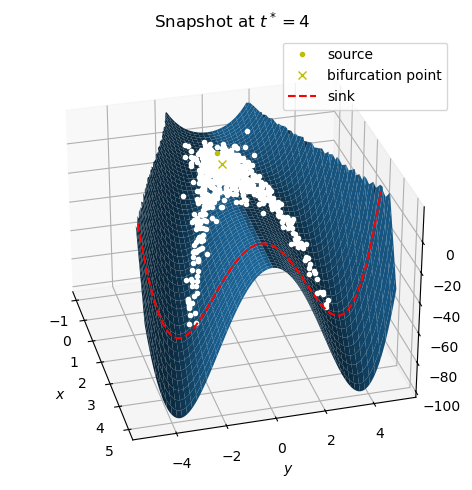

In [22]:
#~~~  Plot the 3d potential and the points sampled  ~~~#

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)  # Shape (nx*ny, 2)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.plot_surface(
    xs, ys, z_plot.reshape(xs.shape),
)

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    jax.vmap(phi)(sampled_cells),
    'w.'
)

# Plot the source point
ax.plot(*source_point, phi(source_point), 'y.', label='source')

# Plot the bifurcation point
ax.plot(x_crit, 0., phi([x_crit, 0]), 'yx', label='bifurcation point')

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
phi_sink = jax.vmap(phi)(np.array([xs_sink, ys_sink]).T).reshape(xs_sink.shape)
phi_sink = np.where(phi_sink > clip, np.nan, phi_sink)
ax.plot(xs_sink, ys_sink, phi_sink, 'r--', label='sink')

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(f"Snapshot at $t^*={tstar}$")
ax.legend()

ax.view_init(30, -15)

plt.tight_layout()

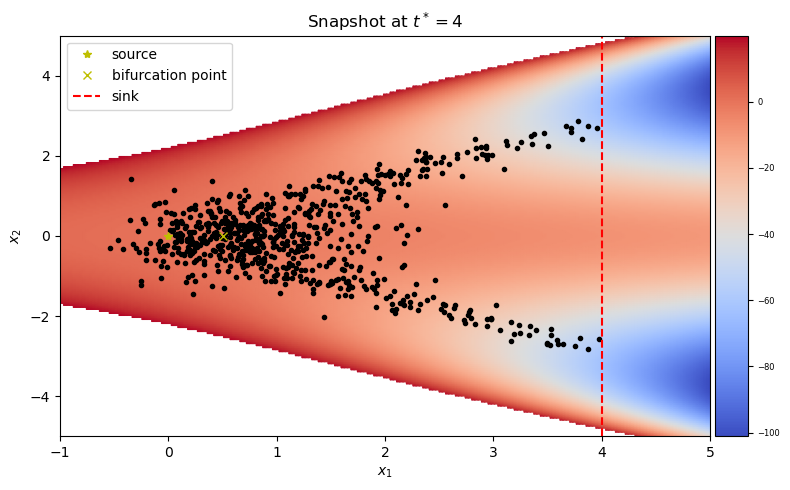

In [23]:
#~~~  Plot a 2d heatmap  ~~~#

fig, ax = plt.subplots(1, 1, figsize=(8,5))

xlims = [
    min(xlims[0], np.min(sampled_cells[:,0].min()) - 0.1),
    max(xlims[1], np.max(sampled_cells[:,0].max()) + 0.1),
]

ylims = [
    min(ylims[0], np.min(sampled_cells[:,1].min()) - 0.1),
    max(ylims[1], np.max(sampled_cells[:,1].max()) + 0.1),
]

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)  # Shape (nx*ny, 2)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.pcolormesh(
    xs, ys, z_plot.reshape(xs.shape),
    vmin=z[under_cutoff].min(),
    vmax=z[under_cutoff].max(),
    cmap='coolwarm', 
    shading="gouraud",
)

# Colorbar
fig = ax.figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.set_title("", size=6)
cbar.ax.tick_params(labelsize=6)

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    'k.'
)

# Plot the source point
ax.plot(*source_point, 'y*', label="source")

# Plot the bifurcation point
ax.plot(x_crit, 0., 'yx', label="bifurcation point")

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
ax.plot(xs_sink, ys_sink, 'r--', label='sink',)

ax.legend()
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title(f"Snapshot at $t^*={tfin}$")

plt.tight_layout()